In [1]:
import h2o
import os
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

## Load data and initialize h2o

In [2]:
with open('data/cc_merged_0516.pkl', 'rb') as f:
    rawdata = pickle.load(f)

In [3]:
rawdata.head()

,index,year,caseid,opinion_type,judge_name,decision,date,Author,Affirmed,AffirmedInPart,...,x_apptoter_dm,x_term_dm,x_circuit_dm,x_hdem_dm,x_hrep_dm,x_sdem_dm,x_srep_dm,x_hother_dm,x_sother_dm,x_agecommi_dm
0,2304,1993,X35807,contentMajOp,PER CURIAM,affirmed,1993-08-04,,1.0,0.0,...,2517.818182,-0.425676,-0.864865,-49.635135,49.371622,-7.459459,2.614865,0.810811,0.986486,6.472973
1,2796,1992,X3AD9D,contentMajOp,LOGAN,affirmed,1992-11-13,LOGAN,1.0,0.0,...,NaN,-0.203704,0.351852,-6.370370,7.629630,10.259259,-10.259259,-0.074074,0.000000,-4.314815
2,2805,1992,X3ADTB,contentMajOp,LOGAN,reversed,1992-12-29,LOGAN,0.0,0.0,...,NaN,-0.203704,0.351852,-6.370370,7.629630,10.259259,-10.259259,-0.074074,0.000000,-4.314815
3,2814,1997,X37GPR,contentMajOp,JOHN C,affirmed,1997-02-11,PORFILIO,1.0,0.0,...,NaN,-0.126761,0.000000,-4.577465,5.478873,10.901408,-10.901408,-0.281690,0.000000,-4.112676
4,2816,1999,X4QAM7,contentMajOp,HOLLOWAY,affirmed,1999-01-04,HOLLOWAY,1.0,0.0,...,NaN,-0.115942,0.028986,-2.855072,4.231884,10.536232,-10.536232,-0.304348,0.000000,-4.478261


In [4]:
h2o.init(max_mem_size = "2G")             #specify max number of bytes. uses all cores by default.
h2o.remove_all()                          #clean slate, in case cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_131"; Java(TM) SE Runtime Environment (build 1.8.0_131-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /Users/wangruofan/anaconda3/envs/py36/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/xk/q16tpt9s72q2g2nvfv69nvcw0000gn/T/tmphrr78n3k
  JVM stdout: /var/folders/xk/q16tpt9s72q2g2nvfv69nvcw0000gn/T/tmphrr78n3k/h2o_wangruofan_started_from_python.out
  JVM stderr: /var/folders/xk/q16tpt9s72q2g2nvfv69nvcw0000gn/T/tmphrr78n3k/h2o_wangruofan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.7
H2O cluster version age:,1 month and 4 days
H2O cluster name:,H2O_from_python_wangruofan_s7jdir
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [5]:
rawdata = h2o.H2OFrame(python_obj=rawdata)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
rawdata.shape

(8434, 253)

In [7]:
rawdata.head()

index,year,caseid,opinion_type,judge_name,decision,date,Author,Affirmed,AffirmedInPart,Reversed,ReversedInPart,Vacated,VacatedInPart,Circuit,judgeid1,judgeid2,judgeid3,id_x,fullname_x,lastname_x,firstname_x,middlename_x,suffix_x,id_y,fullname_y,lastname_y,firstname_y,middlename_y,suffix_y,id,fullname,lastname,firstname,middlename,suffix,month_3_b,month_3,length_3m_dif,txt,x_dem_x_dm,x_republican_x_dm,x_instate_ba_x_dm,x_elev_x_dm,x_unity_x_dm,x_aba_x_dm,x_crossa_x_dm,x_pfedjdge_x_dm,x_pindreg1_x_dm,x_plawprof_x_dm,x_pscab_x_dm,x_pcab_x_dm,x_pusa_x_dm,x_pssenate_x_dm,x_paag_x_dm,x_psp_x_dm,x_pslc_x_dm,x_pssc_x_dm,x_pshouse_x_dm,x_psg_x_dm,x_psgo_x_dm,x_psenate_x_dm,x_psatty_x_dm,x_pprivate_x_dm,x_pmayor_x_dm,x_plocct_x_dm,x_phouse_x_dm,x_pgov_x_dm,x_pda_x_dm,x_pcc_x_dm,x_pccoun_x_dm,x_pausa_x_dm,x_pasatty_x_dm,x_pag_x_dm,x_pada_x_dm,x_pgovt_x_dm,x_llm_sjd_x_dm,x_protestant_x_dm,x_evangelical_x_dm,x_mainline_x_dm,x_noreligion_x_dm,x_catholic_x_dm,x_jewish_x_dm,x_black_x_dm,x_nonwhite_x_dm,x_female_x_dm,x_jd_public_x_dm,x_ba_public_x_dm,x_b10s_x_dm,x_b20s_x_dm,x_b30s_x_dm,x_b40s_x_dm,x_b50s_x_dm,x_pbank_x_dm,x_pmag_x_dm,x_ageon40s_x_dm,x_ageon50s_x_dm,x_ageon60s_x_dm,x_ageon40orless_x_dm,x_ageon70ormore_x_dm,x_pago_x_dm,x_apptoter_x_dm,x_term_x_dm,x_circuit_x_dm,x_hdem_x_dm,x_hrep_x_dm,x_sdem_x_dm,x_srep_x_dm,x_hother_x_dm,x_sother_x_dm,x_agecommi_x_dm,x_dem_y_dm,x_republican_y_dm,x_instate_ba_y_dm,x_elev_y_dm,x_unity_y_dm,x_aba_y_dm,x_crossa_y_dm,x_pfedjdge_y_dm,x_pindreg1_y_dm,x_plawprof_y_dm,x_pscab_y_dm,x_pcab_y_dm,x_pusa_y_dm,x_pssenate_y_dm,x_paag_y_dm,x_psp_y_dm,x_pslc_y_dm,x_pssc_y_dm,x_pshouse_y_dm,x_psg_y_dm,x_psgo_y_dm,x_psenate_y_dm,x_psatty_y_dm,x_pprivate_y_dm,x_pmayor_y_dm,x_plocct_y_dm,x_phouse_y_dm,x_pgov_y_dm,x_pda_y_dm,x_pcc_y_dm,x_pccoun_y_dm,x_pausa_y_dm,x_pasatty_y_dm,x_pag_y_dm,x_pada_y_dm,x_pgovt_y_dm,x_llm_sjd_y_dm,x_protestant_y_dm,x_evangelical_y_dm,x_mainline_y_dm,x_noreligion_y_dm,x_catholic_y_dm,x_jewish_y_dm,x_black_y_dm,x_nonwhite_y_dm,x_female_y_dm,x_jd_public_y_dm,x_ba_public_y_dm,x_b10s_y_dm,x_b20s_y_dm,x_b30s_y_dm,x_b40s_y_dm,x_b50s_y_dm,x_pbank_y_dm,x_pmag_y_dm,x_ageon40s_y_dm,x_ageon50s_y_dm,x_ageon60s_y_dm,x_ageon40orless_y_dm,x_ageon70ormore_y_dm,x_pago_y_dm,x_apptoter_y_dm,x_term_y_dm,x_circuit_y_dm,x_hdem_y_dm,x_hrep_y_dm,x_sdem_y_dm,x_srep_y_dm,x_hother_y_dm,x_sother_y_dm,x_agecommi_y_dm,x_dem_dm,x_republican_dm,x_instate_ba_dm,x_elev_dm,x_unity_dm,x_aba_dm,x_crossa_dm,x_pfedjdge_dm,x_pindreg1_dm,x_plawprof_dm,x_pscab_dm,x_pcab_dm,x_pusa_dm,x_pssenate_dm,x_paag_dm,x_psp_dm,x_pslc_dm,x_pssc_dm
2304,1993,X35807,contentMajOp,PER CURIAM,affirmed,1993-08-04 00:00:00,,1,0,0,0,0,0,11,1317,176,2427,1317,"KRAVITCH, PHYLLIS A.",KRAVITCH,PHYLLIS,A.,,176,"BIRCH, STANLEY F., JR.",BIRCH,STANLEY,F.,JR.,2427,"TUTTLE, ELBERT PARR",TUTTLE,ELBERT,PARR,,1993-05-04 00:00:00,1993-11-04 00:00:00,-1.09914,,0.601351,-0.601351,-0.439189,-0.317568,0.594595,0.878378,-0.0540541,-0.317568,-0.0945946,-0.155405,0,0,-0.0202703,0,0,0,0.824324,-0.141892,-0.0135135,0,0,0,-0.216216,0.0202703,0,-0.0202703,0,0,-0.189189,0,0,-0.0675676,nan,0,-0.0743243,0.324324,0,-0.614865,-0.00675676,-0.608108,-0.0540541,-0.175676,0.891892,-0.0202703,-0.0675676,0.905405,-0.466216,-0.378378,-0.0945946,0.72973,-0.418919,-0.216216,0,0,-0.0202703,-0.554054,0.668919,-0.0743243,-0.0405405,0,-0.0472973,-4159.12,-0.317568,0,10.7635,-10.6014,3.29054,-3.19595,-0.0608108,-0.00675676,9.37838,-0.337838,0.337838,-0.52027,-0.304054,-0.344595,0.844595,-0.0743243,-0.304054,-0.141892,-0.101351,0,0,-0.00675676,-0.00675676,0,0,-0.141892,-0.128378,-0.0135135,0,0,0,-0.128378,0.0405405,0,-0.0202703,0,0,-0.0810811,0,0,-0.0810811,nan,0,-0.0472973,-0.635135,0.959459,0.47973,-0.00675676,0.486486,-0.0337838,-0.25,-0.141892,-0.0135135,-0.0675676,-0.135135,-0.533784,0.574324,-0.121622,-0.141892,-0.513514,0.790541,-0.0135135,0,-0.0405405,0.5,-0.331081,-0.128378,-0.0405405,0,-0.0540541,-30.9552,-0.304054,5.39865,-3.85135,4.33108,0.0202703,0.0878378,-0.0945946,-0.00675676,-4

In [106]:
#h2o groupby example
rawdata.group_by("opinion_type").sum('Affirmed').get_frame()

opinion_type,sum_Affirmed
contentConDisOp1,17
contentConOp,8
contentConOp1,32
contentConOp2,3
contentConPartOp,5
contentDisOp,7
contentDisOp1,63
contentDisPartOp,5
contentMajOp,5828
contentPerCurOp,119


In [9]:
rawdata.col_names

['index',
 'year',
 'caseid',
 'opinion_type',
 'judge_name',
 'decision',
 'date',
 'Author',
 'Affirmed',
 'AffirmedInPart',
 'Reversed',
 'ReversedInPart',
 'Vacated',
 'VacatedInPart',
 'Circuit',
 'judgeid1',
 'judgeid2',
 'judgeid3',
 'id_x',
 'fullname_x',
 'lastname_x',
 'firstname_x',
 'middlename_x',
 'suffix_x',
 'id_y',
 'fullname_y',
 'lastname_y',
 'firstname_y',
 'middlename_y',
 'suffix_y',
 'id',
 'fullname',
 'lastname',
 'firstname',
 'middlename',
 'suffix',
 'month_3_b',
 'month_3',
 'length_3m_dif',
 'txt',
 'x_dem_x_dm',
 'x_republican_x_dm',
 'x_instate_ba_x_dm',
 'x_elev_x_dm',
 'x_unity_x_dm',
 'x_aba_x_dm',
 'x_crossa_x_dm',
 'x_pfedjdge_x_dm',
 'x_pindreg1_x_dm',
 'x_plawprof_x_dm',
 'x_pscab_x_dm',
 'x_pcab_x_dm',
 'x_pusa_x_dm',
 'x_pssenate_x_dm',
 'x_paag_x_dm',
 'x_psp_x_dm',
 'x_pslc_x_dm',
 'x_pssc_x_dm',
 'x_pshouse_x_dm',
 'x_psg_x_dm',
 'x_psgo_x_dm',
 'x_psenate_x_dm',
 'x_psatty_x_dm',
 'x_pprivate_x_dm',
 'x_pmayor_x_dm',
 'x_plocct_x_dm',
 'x_p

In [10]:
# de-mean for x_dem
# rawdata[:,"x_dem"] -= rawdata[:,"x_dem_p"]

In [11]:
# rawdata[:,"x_dem_y"] -= rawdata[:,"x_dem_p"]
# rawdata[:,"x_dem_x"] -= rawdata[:,"x_dem_p"]

## Generate target variable

In [12]:
data = rawdata[sum(rawdata[:,["Affirmed","AffirmedInPart","Reversed","ReversedInPart","Vacated","VacatedInPart"]]) == 1,:]#.sum(axis=0)
data["res"] = 0

# data = data.as_data_frame(use_pandas=True)
# data = data[data["res"] == 1,:] 
# data = h2o.H2OFrame(data)
data[data["Affirmed"] == 1, "res"] = 1
data[data["Reversed"] == 1, "res"] = 2
data[data["Vacated"] == 1, "res"] = 2
# # data_r = data[data["res"] == "Reversed"]
# # data_a = data[data["res"] == "Affirmed"]
# # data = data_r.append(data_a)

In [13]:
# data = data.drop("x_dem_p", 1)

In [14]:
data_bio = data[:,["index"]+[c for c in data.columns if c[:2] == "x_"]].cbind(data["res"])

In [15]:
data_bio.col_names[213]

'x_agecommi_dm'

## Sum 3 Judges

### Random Forest

In [16]:
#sum up three judges
for i in range(143, 213 + 1):
    data_bio[:,i] += data_bio[:,i - 71] + data_bio[:,i - 142]
data_bio_sumed = data_bio["index"].cbind(data_bio[:,143:])
data_bio_sumed.show()

index,x_dem_dm,x_republican_dm,x_instate_ba_dm,x_elev_dm,x_unity_dm,x_aba_dm,x_crossa_dm,x_pfedjdge_dm,x_pindreg1_dm,x_plawprof_dm,x_pscab_dm,x_pcab_dm,x_pusa_dm,x_pssenate_dm,x_paag_dm,x_psp_dm,x_pslc_dm,x_pssc_dm,x_pshouse_dm,x_psg_dm,x_psgo_dm,x_psenate_dm,x_psatty_dm,x_pprivate_dm,x_pmayor_dm,x_plocct_dm,x_phouse_dm,x_pgov_dm,x_pda_dm,x_pcc_dm,x_pccoun_dm,x_pausa_dm,x_pasatty_dm,x_pag_dm,x_pada_dm,x_pgovt_dm,x_llm_sjd_dm,x_protestant_dm,x_evangelical_dm,x_mainline_dm,x_noreligion_dm,x_catholic_dm,x_jewish_dm,x_black_dm,x_nonwhite_dm,x_female_dm,x_jd_public_dm,x_ba_public_dm,x_b10s_dm,x_b20s_dm,x_b30s_dm,x_b40s_dm,x_b50s_dm,x_pbank_dm,x_pmag_dm,x_ageon40s_dm,x_ageon50s_dm,x_ageon60s_dm,x_ageon40orless_dm,x_ageon70ormore_dm,x_pago_dm,x_apptoter_dm,x_term_dm,x_circuit_dm,x_hdem_dm,x_hrep_dm,x_sdem_dm,x_srep_dm,x_hother_dm,x_sother_dm,x_agecommi_dm,res
2304,0.00675676,-0.00675676,-1.46622,-1.0473,0.97973,0.547297,-0.202703,-1.0473,0.614865,-0.418919,-0.00680272,0,-0.0337838,-0.0202703,-0.00680272,0,0.540541,-0.371622,-0.0405405,0,0,0,-0.5,0.108108,0,-0.0878378,0,0,-0.364865,0,0,-0.189189,nan,0,-0.202703,-0.0202703,0.918919,0.277027,-0.027027,0.304054,-0.162162,-0.648649,0.662162,-0.0472973,-0.222973,0.682432,-1.49324,-0.202703,-0.324324,0.459459,-1.4527,0.351351,-0.027027,0,-0.0810811,-0.513514,0.986486,-0.351351,-0.121622,0,-0.135135,nan,-1.0473,4.53378,-42.723,43.1014,-4.14865,-0.493243,0.655405,0.972973,10.8716,1
2796,1.16667,-1.16667,-0.185185,-0.62963,1.16667,-0.037037,0,-0.62963,-0.333333,-0.0740741,-0.0740741,0,0,-0.0185185,-0.0740741,0,-0.333333,-0.222222,-0.240741,0,0,0,0.037037,0,0,-0.222222,0,0,0.351852,0,0,0,nan,0,-0.222222,-0.703704,-0.0740741,0.185185,-0.166667,0.222222,0,0.222222,0,0,0,-0.407407,-0.888889,0.722222,-0.425926,2.37037,-1.2037,-0.740741,0,-0.314815,0,1.85185,-1.44444,0,-0.407407,0,0.574074,nan,-0.62963,0.962963,-12.7593,-13.3889,17.7222,-17.7222,-0.222222,0,-5.33333,1
2805,1.16667,-1.16667,-0.185185,-0.62963,1.16667,-0.037037,0,-0.62963,-0.333333,-0.0740741,-0.0740741,0,0,-0.0185185,-0.0740741,0,-0.333333,-0.222222,-0.240741,0,0,0,0.037037,0,0,-0.222222,0,0,0.351852,0,0,0,nan,0,-0.222222,-0.703704,-0.0740741,0.185185,-0.166667,0.222222,0,0.222222,0,0,0,-0.407407,-0.888889,0.722222,-0.425926,2.37037,-1.2037,-0.740741,0,-0.314815,0,1.85185,-1.44444,0,-0.407407,0,0.574074,nan,-0.62963,0.962963,-12.7593,-13.3889,17.7222,-17.7222,-0.222222,0,-5.33333,2
2814,-0.28169,0.28169,0.943662,0.549296,0.338028,0.338028,0,0.549296,-1.04225,-1.22535,-0.0172414,0,0,0,0,0,-0.535211,-0.126761,-0.408451,0,0,0,0.323944,0.225352,0,-0.126761,-0.0140845,0,-0.295775,0,0,-0.225352,nan,0,-0.126761,1.1831,-0.225352,-0.352113,-0.0704225,-0.352113,-0.225352,-0.084507,0,0,-0.211268,-0.56338,0.15493,-0.323944,-0.140845,0.633803,1.14085,-1.50704,-0.126761,0.746479,0,-0.380282,0.71831,0,-0.338028,0,1.66197,nan,0.549296,0.126761,6.35211,-3.91549,-0.0140845,0.0140845,-1.02817,0,2.56338,1
2816,-0.202899,0.202899,0.942029,0.507246,0.434783,1.11594,0,0.507246,-0.0869565,-0.42029,0,0,0,0,0,0,-0.550725,-0.130435,-0.405797,0,0,0,0.231884,0.173913,0,-0.130435,0,0,-0.449275,0,0,-0.173913,nan,0,-0.130435,0.0724638,-0.173913,0.637681,-0.231884,0.637681,-0.173913,-0.0724638,0,0,-0.217391,0.57971,-0.0144928,0.608696,-0.130435,0.652174,0.0724638,-0.42029,-0.173913,0.855072,0,-0.57971,-0.173913,0,0.753623,0,0.782609,nan,0.507246,0.0289855,11.2029,-8.3913,0.434783,-0.434783,-1.04348,0,-12.2899,1
2817,0.728571,-0.728571,0.814286,0.457143,1.41429,0.157143,-0.0142857,0.457143,-1.07143,-0.257143,0,0,0,0,0,0,-0.628571,-0.0714286,0.642857,0,0,0,1.21429,0.357143,0,-0.0714286,0,0,-0.4,0,0,-0.342857,nan,0,-0.0857143,1.05714,-0.342857,-0.228571,-0.214286,-0.228571,-0.342857,0.928571,0,0,-0.157143,-0.542857,-0.0714286,0.5,-0.0714286,0.471429,0.0714286,-1.34286,0.871429,0.757143,0,0.314286,-0.114286,0,-0.2,0,0.742857,nan,0.457143,0.0714286,19.2571,-16.1857,10.8143,-10.8143,-0.0428571,0,-10.2,1
2819,-0.266667,0.266667,0.533333,0.466667,-0.266667,-0.333333,0,0.466

In [17]:
#modelling
#X : bio_data_sumed
#y : data["res"] == 1 or 2
filt = data_bio_sumed["res"] != 0
data_bio_sumed_filt = data_bio_sumed[filt]
data_bio_sumed_filt["res"] = data_bio_sumed_filt["res"].asfactor()

In [18]:
#train_test_split
train, test, val = data_bio_sumed_filt.split_frame(ratios=[.7, .15])

In [19]:
#fit a random forest
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_v1",
    ntrees=120,
    max_depth = 6,
#     stopping_rounds=2,
    score_each_iteration=True,
    seed=10000)

In [20]:
train_X = train.col_names[1:-1]     #last column is Cover_Type, our desired response variable 
train_y = train.col_names[-1]
rf_v1.train(train_X, train_y, training_frame=train, validation_frame=val)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [21]:
pred = rf_v1.predict(val[:,1:-1]).as_data_frame().as_matrix()[:,-2:].ravel()
true = pd.get_dummies(val[:,-1].as_data_frame().as_matrix().flatten()).values.ravel()
print("AUC Score calculaed by sklearn")
roc_auc_score(true, pred)

drf prediction progress: |████████████████████████████████████████████████| 100%
AUC Score calculaed by sklearn


0.8624306441326531

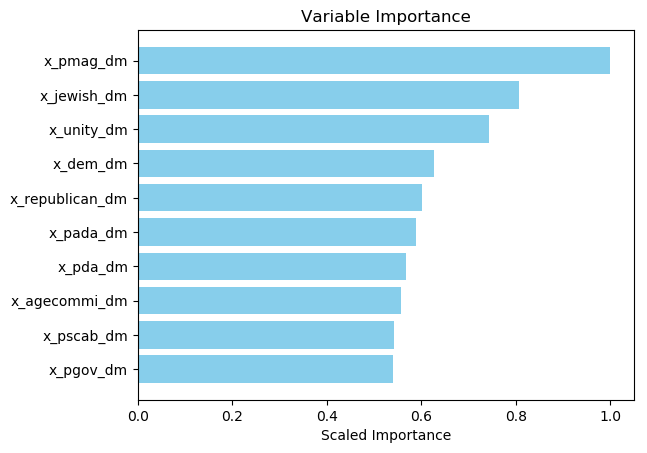

,variable,relative_importance,scaled_importance,percentage
0,x_pmag_dm,281.331573,1.000000,0.042373
1,x_jewish_dm,226.913651,0.806570,0.034177
2,x_unity_dm,209.038651,0.743033,0.031485
3,x_dem_dm,176.248978,0.626481,0.026546
4,x_republican_dm,169.305237,0.601800,0.025500
5,x_pada_dm,165.442154,0.588068,0.024918
6,x_pda_dm,159.879333,0.568295,0.024081
7,x_agecommi_dm,156.575043,0.556550,0.023583
8,x_pscab_dm,152.391159,0.541678,0.022953
9,x_pgov_dm,151.704865,0.539239,0.022849


In [67]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = rf_v1._model_json['output']['variable_importances']['variable']
y_pos = np.arange(10)
scaled_importance = rf_v1._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance[:10], align='center', color='skyblue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.savefig('imp.png')
plt.show()

rf_v1._model_json['output']['variable_importances'].as_data_frame()

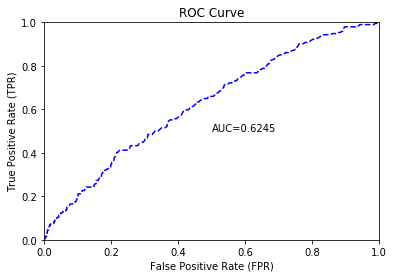

In [27]:
perf = rf_v1.model_performance(valid = True)
perf.plot()

In [69]:
rf_v1.r2()

0.03002355443442606

### Gradient Boost

In [61]:
gbm1 = H2OGradientBoostingEstimator()
gbm1.train(train_X, train_y, training_frame=train, validation_frame=val)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [62]:
pred = gbm1.predict(val[:,1:-1]).as_data_frame().as_matrix()[:,-2:].ravel()
true = pd.get_dummies(val[:,-1].as_data_frame().as_matrix().flatten()).values.ravel()
print("AUC Score calculaed by sklearn")
roc_auc_score(true, pred)

gbm prediction progress: |████████████████████████████████████████████████| 100%
AUC Score calculaed by sklearn


ValueError: Found input variables with inconsistent numbers of samples: [4530, 2265]

In [63]:
gbm1.confusion_matrix(valid=True)

AttributeError: type object 'H2OGradientBoostingEstimator' has no attribute 'confusion_matrix'

In [41]:
gbm1.model_performance(valid=True)


ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14126951291221995
RMSE: 0.375858368155107
LogLoss: 0.4553177271022231
Mean Per-Class Error: 0.42782681586246085
AUC: 0.5829606251371284
Gini: 0.16592125027425686
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14426825422974204: 


,1,2,Error,Rate
1,362.0,559.0,0.6069,(559.0/921.0)
2,48.0,145.0,0.2487,(48.0/193.0)
Total,410.0,704.0,0.5449,(607.0/1114.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1442683,0.3232999,269.0
max f2,0.0638062,0.5143923,392.0
max f0point5,0.2865151,0.2707930,61.0
max accuracy,0.6760512,0.8276481,0.0
max precision,0.6760512,1.0,0.0
max recall,0.0638062,1.0,392.0
max specificity,0.6760512,1.0,0.0
max absolute_mcc,0.3391513,0.1459865,35.0
max min_per_class_accuracy,0.1684460,0.5580890,220.0
max mean_per_class_accuracy,0.1442683,0.5721732,269.0


Gains/Lift Table: Avg response rate: 17.32 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0107720,0.4509273,2.4050086,2.4050086,0.4166667,0.4166667,0.0259067,0.0259067,140.5008636,140.5008636
,2,0.0206463,0.4016873,2.6236458,2.5095742,0.4545455,0.4347826,0.0259067,0.0518135,162.3645784,150.9574228
,3,0.0305206,0.3596659,2.0989166,2.3767144,0.3636364,0.4117647,0.0207254,0.0725389,109.8916627,137.6714416
,4,0.0403950,0.3308778,2.6236458,2.4370754,0.4545455,0.4222222,0.0259067,0.0984456,162.3645784,143.7075417
,5,0.0502693,0.3124522,1.0494583,2.1645078,0.1818182,0.375,0.0103627,0.1088083,4.9458314,116.4507772
,6,0.1014363,0.2702452,1.2151623,1.6856344,0.2105263,0.2920354,0.0621762,0.1709845,21.5162258,68.5634371
,7,0.1499102,0.2399009,1.1757820,1.5207719,0.2037037,0.2634731,0.0569948,0.2279793,17.5782000,52.0771928
,8,0.2001795,0.2209898,0.8245744,1.3459421,0.1428571,0.2331839,0.0414508,0.2694301,-17.5425611,34.5942053
,9,0.2998205,0.1955122,0.9360034,1.2097049,0.1621622,0.2095808,0.0932642,0.3626943,-6.3996639,20.9704942
,10,0.4012567,0.1770481,0.9194369,1.1363262,0.1592920,0.1968680,0.0932642,0.4559585,-8.0563070,13.6326228


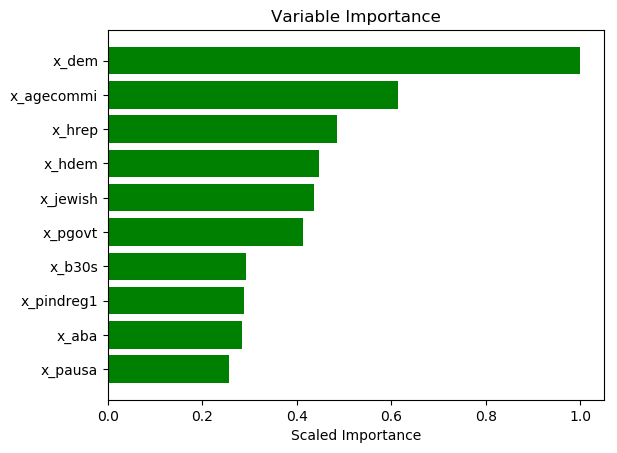

,variable,relative_importance,scaled_importance,percentage
0,x_dem,60.225193,1.000000,0.100011
1,x_agecommi,36.953579,0.613590,0.061366
2,x_hrep,29.230101,0.485347,0.048540
3,x_hdem,26.867178,0.446112,0.044616
4,x_jewish,26.258240,0.436001,0.043605
5,x_pgovt,24.842758,0.412498,0.041254
6,x_b30s,17.567852,0.291703,0.029174
7,x_pindreg1,17.377985,0.288550,0.028858
8,x_aba,17.134638,0.284509,0.028454
9,x_pausa,15.491832,0.257232,0.025726


In [42]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = gbm1._model_json['output']['variable_importances']['variable']
y_pos = np.arange(10)
scaled_importance = gbm1._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance[:10], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

gbm1._model_json['output']['variable_importances'].as_data_frame()

In [ ]:
## sort the grid models by decreasing AUC
sorted_grid = grid.get_grid(sort_by='auc',decreasing=True)
print(sorted_grid)

### Top 10 -> Logistics Regression

In [58]:
top_fea = ["x_agecommi", "x_republican", "x_dem", "x_jewish", "x_hrep", "x_srep", "x_hdem", "x_sdem", "x_aba", "x_catholic"]
lr_v1 = H2OGeneralizedLinearEstimator(
                    model_id='lr1',            #allows us to easily locate this model in Flow
                    family='binomial',
                    solver='L_BFGS')
lr_v1.train(top_fea, train_y, training_frame = train, validation_frame = val)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [59]:
lr_v1.coef_norm()

{'Intercept': -1.5497769029081623,
 'x_aba': 0.06128019584427073,
 'x_agecommi': 0.005700507086026832,
 'x_catholic': -0.1521656657572737,
 'x_dem': 0.09545040571537704,
 'x_hdem': -0.08478928223694247,
 'x_hrep': 0.00521757988373322,
 'x_jewish': 0.05591723363060835,
 'x_republican': -0.087324278063713,
 'x_sdem': 0.04281443481041659,
 'x_srep': -0.034419013832871874}

In [25]:
help(H2OGeneralizedLinearEstimator)

Help on class H2OGeneralizedLinearEstimator in module h2o.estimators.glm:

class H2OGeneralizedLinearEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Generalized Linear Modeling
 |  
 |  Fits a generalized linear model, specified by a response variable, a set of predictors, and a
 |  description of the error distribution.
 |  
 |  A subclass of :class:`ModelBase` is returned. The specific subclass depends on the machine learning task
 |  at hand (if it's binomial classification, then an H2OBinomialModel is returned, if it's regression then a
 |  H2ORegressionModel is returned). The default print-out of the models is shown, but further GLM-specific
 |  information can be queried out of the object. Upon completion of the GLM, the resulting object has
 |  coefficients, normalized coefficients, residual/null deviance, aic, and a host of model metrics including
 |  MSE, AUC (for logistic regression), degrees of freedom, and confusion matrices.
 |  
 |  Method resolution order:
 |  

## Un-sum 3 Judges

### Random Forsest

In [223]:
#modelling using only un-summed biodata
#fit a random forest
rf_v2 = H2ORandomForestEstimator(
    model_id="rf_v2",
    ntrees=120,
    max_depth = 6,
#     stopping_rounds=2,
    score_each_iteration=True,
    seed=10000)
data_bio_filt = data_bio[data_bio["res"] != 0]
data_bio_filt["res"] = data_bio_filt["res"].asfactor()
train, test, val = data_bio_filt.split_frame(ratios=[.7, .15])
train_X = train.col_names[:-1]     #last column is Cover_Type, our desired response variable 
train_y = train.col_names[-1]
rf_v2.train(train_X, train_y, training_frame=train, validation_frame=val)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [240]:
rf_v2.model_performance()


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1420330474230797
RMSE: 0.37687272045490333
LogLoss: 0.4536058255499541
Mean Per-Class Error: 0.39911247737808964
AUC: 0.6380272985808846
Gini: 0.27605459716176917
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16470082975684974: 


,1,2,Error,Rate
1,2325.0,1921.0,0.4524,(1921.0/4246.0)
2,322.0,609.0,0.3459,(322.0/931.0)
Total,2647.0,2530.0,0.4333,(2243.0/5177.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1647008,0.3519214,249.0
max f2,0.1203184,0.5362042,335.0
max f0point5,0.2518933,0.3005544,127.0
max accuracy,0.5094048,0.8205524,1.0
max precision,0.5542339,1.0,0.0
max recall,0.0471008,1.0,399.0
max specificity,0.5542339,1.0,0.0
max absolute_mcc,0.1830801,0.1613598,218.0
max min_per_class_accuracy,0.1707574,0.5972073,237.0
max mean_per_class_accuracy,0.1830801,0.6008875,218.0


Gains/Lift Table: Avg response rate: 17.98 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100444,0.3926641,2.5664711,2.5664711,0.4615385,0.4615385,0.0257787,0.0257787,156.6471123,156.6471123
,2,0.0200889,0.3607766,2.2456622,2.4060667,0.4038462,0.4326923,0.0225564,0.0483351,124.5662233,140.6066678
,3,0.0301333,0.3386609,2.5664711,2.4595348,0.4615385,0.4423077,0.0257787,0.0741139,156.6471123,145.9534826
,4,0.0401777,0.3201886,1.9248533,2.3258645,0.3461538,0.4182692,0.0193340,0.0934479,92.4853342,132.5864455
,5,0.0500290,0.3070229,1.1993640,2.1040439,0.2156863,0.3783784,0.0118153,0.1052632,19.9363956,110.4043894
,6,0.1000579,0.2633099,1.6746472,1.8893455,0.3011583,0.3397683,0.0837809,0.1890440,67.4647181,88.9345537
,7,0.1500869,0.2401846,1.3096600,1.6961170,0.2355212,0.3050193,0.0655209,0.2545650,30.9659975,69.6117016
,8,0.2001159,0.2224068,1.3955393,1.6209726,0.2509653,0.2915058,0.0698174,0.3243824,39.5539317,62.0972591
,9,0.2999807,0.1955345,1.3121932,1.5181787,0.2359768,0.2730200,0.1310419,0.4554243,31.2193166,51.8178668
,10,0.4000386,0.1755159,1.0627569,1.4042682,0.1911197,0.2525350,0.1063373,0.5617615,6.2756865,40.4268241


In [225]:
pred = rf_v2.predict(val[:,:-1]).as_data_frame().as_matrix()[:,-2:].ravel()
true = pd.get_dummies(val[:,-1].as_data_frame().as_matrix().flatten()).values.ravel()
roc_auc_score(true, pred)

drf prediction progress: |████████████████████████████████████████████████| 100%


0.8530978672204002

In [242]:
rf_v2.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15164842498799166: 


,1,2,Error,Rate
1,381.0,554.0,0.5925,(554.0/935.0)
2,50.0,150.0,0.25,(50.0/200.0)
Total,431.0,704.0,0.5322,(604.0/1135.0)


## Generalize

In [70]:
data_bio_sumed_filt.shape

(7388, 73)

In [71]:
all_pred = rf_v1.predict(data_bio_sumed_filt[:,1:-1]).as_data_frame().as_matrix()[:,-2:]

drf prediction progress: |████████████████████████████████████████████████| 100%


In [72]:
rf_v1.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17094308502972125: 


,1,2,Error,Rate
1,521.0,416.0,0.444,(416.0/937.0)
2,69.0,126.0,0.3538,(69.0/195.0)
Total,590.0,542.0,0.4284,(485.0/1132.0)


In [75]:
deci = [ls[1] > 0.17094308502972125 for ls in all_pred]

In [76]:
sum(deci)

3020

In [77]:
data_bio_sumed_filt[:,"pred"] = h2o.H2OFrame(deci)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [78]:
data_bio_sumed_filt = data_bio_sumed_filt[:,["index","pred","res"]]
data_bio_sumed_filt.summary()

,index,pred,res
type,int,enum,enum
mins,2304.0,,
mean,30330.65349214945,,
maxs,42969.0,,
sigma,8830.204860800615,,
zeros,0,,
missing,0,0,0
0,2304.0,False,1
1,2796.0,True,1
2,2805.0,True,2


In [79]:
data_out = rawdata.merge(data_bio_sumed_filt, all_x=True, by_x=["index"], by_y=["index"])

In [80]:
data_out = data_out.drop("txt", 1)

In [81]:
data_out = data_out.as_data_frame(use_pandas=True)

In [82]:
data_out.ix[data_out["pred"] == True, "pred"] = "Rev"

In [83]:
data_out.ix[data_out["pred"] == False, "pred"] = "Aff"

In [84]:
data_out.pred.value_counts()

Aff    4368
Rev    3020
Name: pred, dtype: int64

In [85]:
data_out

,index,year,caseid,opinion_type,judge_name,decision,date,Author,Affirmed,AffirmedInPart,...,x_circuit_dm,x_hdem_dm,x_hrep_dm,x_sdem_dm,x_srep_dm,x_hother_dm,x_sother_dm,x_agecommi_dm,pred,res
0,2304,1993,X35807,contentMajOp,PER CURIAM,affirmed,744422400000,NaN,1,0,...,-0.864865,-49.635135,49.371622,-7.459459,2.614865,0.810811,0.986486,6.472973,Aff,1.0
1,2796,1992,X3AD9D,contentMajOp,LOGAN,affirmed,721612800000,LOGAN,1,0,...,0.351852,-6.370370,7.629630,10.259259,-10.259259,-0.074074,0.000000,-4.314815,Rev,1.0
2,2805,1992,X3ADTB,contentMajOp,LOGAN,reversed,725587200000,LOGAN,0,0,...,0.351852,-6.370370,7.629630,10.259259,-10.259259,-0.074074,0.000000,-4.314815,Rev,2.0
3,2814,1997,X37GPR,contentMajOp,JOHN C,affirmed,855619200000,PORFILIO,1,0,...,0.000000,-4.577465,5.478873,10.901408,-10.901408,-0.281690,0.000000,-4.112676,Rev,1.0
4,2816,1999,X4QAM7,contentMajOp,HOLLOWAY,affirmed,915408000000,HOLLOWAY,1,0,...,0.028986,-2.855072,4.231884,10.536232,-10.536232,-0.304348,0.000000,-4.478261,Aff,1.0
5,2817,1998,XN5ACRQNB5G0,contentMajOp,JOHN C,affirmed,888192000000,PORFILIO,1,0,...,0.042857,0.728571,1.428571,11.857143,-11.857143,-0.300000,0.000000,-4.057143,Rev,1.0
6,2819,1991,X57EQB,contentMajOp,JOHN P,reversed,692928000000,MOORE,0,0,...,0.466667,-13.466667,13.466667,7.933333,-7.933333,0.000000,0.000000,-4.666667,Aff,2.0
7,2820,1991,XAC38F,contentMajOp,BRORBY,affirmed,694137600000,BRORBY,1,0,...,0.466667,-13.466667,13.466667,7.933333,-7.933333,0.000000,0.000000,-4.666667,Aff,1.0
8,2821,1995,X4NT3Q,contentMajOp,HOLLOWAY,affirmed,813974400000,HOLLOWAY,1,0,...,0.363636,-16.636364,17.757576,8.181818,-8.181818,-0.090909,0.000000,-4.757576,Aff,1.0
9,2822,2000,X3FBF1,contentMajOp,TACHA,affirmed,954806400000,TACHA,1,0,...,0.000000,3.227273,-2.613636,10.795455,-10.795455,-0.477273,0.000000,-3.454545,Aff,1.0


In [86]:
data_out.to_csv("data_bio_sumed_pred.csv")

## Judge -> Text Features

In [87]:
pt1 = pd.read_csv("data/nn_prepared_svd_test.csv", header=0, index_col=0)

In [88]:
pt2 = pd.read_csv("data/nn_prepared_svd_train.csv", header=0, index_col=0)

In [89]:
pt = pt1.append(pt2)

In [90]:
pt.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,index,length_3m_dif,Res_binary
2,0.119560,-0.025109,0.006438,-0.007403,0.016007,-0.019776,0.026116,-0.022396,-0.004759,0.016801,...,-0.028142,0.010797,0.002833,-0.004601,-0.001949,-0.008434,-0.010712,2805,-3.563471,2.0
5,0.225139,-0.005882,-0.016541,-0.041018,0.020817,-0.080179,-0.008049,0.229289,0.192550,-0.001704,...,0.017721,-0.048032,0.018464,-0.028783,0.009282,-0.049668,-0.002731,2817,3.591201,1.0
17,0.335446,-0.088022,-0.039259,-0.161896,-0.059553,0.038914,0.040434,0.014779,-0.039393,-0.038272,...,0.032856,0.022060,0.014375,-0.008793,0.023410,-0.027673,0.010503,3065,0.959357,1.0
18,0.099370,-0.008746,0.038461,0.022877,0.025353,-0.033024,0.035538,-0.004255,-0.004725,0.044369,...,-0.008181,0.050645,0.015305,-0.049081,-0.006768,0.000286,0.020970,3392,-1.595323,1.0
23,0.248678,-0.052279,-0.046643,-0.072322,-0.028227,0.027050,0.023338,0.031693,-0.029706,-0.031873,...,-0.021154,-0.000490,-0.006574,-0.014109,-0.013019,-0.037845,0.009001,3498,-2.045180,1.0


In [116]:
data_bio_sumed_filt_pd = data_bio_sumed_filt.as_data_frame(use_pandas=True)

In [117]:
bio_txt = pd.merge(data_bio_sumed_filt_pd, pt, left_on = "index", right_on = "index")

In [118]:
bio_txt.columns

Index(['index', 'x_dem_dm', 'x_republican_dm', 'x_instate_ba_dm', 'x_elev_dm',
       'x_unity_dm', 'x_aba_dm', 'x_crossa_dm', 'x_pfedjdge_dm',
       'x_pindreg1_dm', 'x_plawprof_dm', 'x_pscab_dm', 'x_pcab_dm',
       'x_pusa_dm', 'x_pssenate_dm', 'x_paag_dm', 'x_psp_dm', 'x_pslc_dm',
       'x_pssc_dm', 'x_pshouse_dm', 'x_psg_dm', 'x_psgo_dm', 'x_psenate_dm',
       'x_psatty_dm', 'x_pprivate_dm', 'x_pmayor_dm', 'x_plocct_dm',
       'x_phouse_dm', 'x_pgov_dm', 'x_pda_dm', 'x_pcc_dm', 'x_pccoun_dm',
       'x_pausa_dm', 'x_pasatty_dm', 'x_pag_dm', 'x_pada_dm', 'x_pgovt_dm',
       'x_llm_sjd_dm', 'x_protestant_dm', 'x_evangelical_dm', 'x_mainline_dm',
       'x_noreligion_dm', 'x_catholic_dm', 'x_jewish_dm', 'x_black_dm',
       'x_nonwhite_dm', 'x_female_dm', 'x_jd_public_dm', 'x_ba_public_dm',
       'x_b10s_dm', 'x_b20s_dm', 'x_b30s_dm', 'x_b40s_dm', 'x_b50s_dm',
       'x_pbank_dm', 'x_pmag_dm', 'x_ageon40s_dm', 'x_ageon50s_dm',
       'x_ageon60s_dm', 'x_ageon40orless_dm', 'x_ag

In [119]:
y_s = ['0', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24']

In [120]:
x_col = ['x_dem_dm', 'x_republican_dm', 'x_instate_ba_dm', 'x_elev_dm',
       'x_unity_dm', 'x_aba_dm', 'x_crossa_dm', 'x_pfedjdge_dm',
       'x_pindreg1_dm', 'x_plawprof_dm', 'x_pscab_dm', 'x_pcab_dm',
       'x_pusa_dm', 'x_pssenate_dm', 'x_paag_dm', 'x_psp_dm', 'x_pslc_dm',
       'x_pssc_dm', 'x_pshouse_dm', 'x_psg_dm', 'x_psgo_dm', 'x_psenate_dm',
       'x_psatty_dm', 'x_pprivate_dm', 'x_pmayor_dm', 'x_plocct_dm',
       'x_phouse_dm', 'x_pgov_dm', 'x_pda_dm', 'x_pcc_dm', 'x_pccoun_dm',
       'x_pausa_dm', 'x_pasatty_dm', 'x_pag_dm', 'x_pada_dm', 'x_pgovt_dm',
       'x_llm_sjd_dm', 'x_protestant_dm', 'x_evangelical_dm', 'x_mainline_dm',
       'x_noreligion_dm', 'x_catholic_dm', 'x_jewish_dm', 'x_black_dm',
       'x_nonwhite_dm', 'x_female_dm', 'x_jd_public_dm', 'x_ba_public_dm',
       'x_b10s_dm', 'x_b20s_dm', 'x_b30s_dm', 'x_b40s_dm', 'x_b50s_dm',
       'x_pbank_dm', 'x_pmag_dm', 'x_ageon40s_dm', 'x_ageon50s_dm',
       'x_ageon60s_dm', 'x_ageon40orless_dm', 'x_ageon70ormore_dm',
       'x_pago_dm', 'x_apptoter_dm', 'x_term_dm', 'x_circuit_dm', 'x_hdem_dm',
       'x_hrep_dm', 'x_sdem_dm', 'x_srep_dm', 'x_hother_dm', 'x_sother_dm',
       'x_agecommi_dm']

In [121]:
bio_txt_h = h2o.H2OFrame(python_obj=bio_txt)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [122]:
train, val = bio_txt_h.split_frame(ratios=[.7])

In [123]:
pred = {}
r2 = {}

for y in y_s:
    print("now training :", y)
    train_X = x_col     #last column is Cover_Type, our desired response variable 
    train_y = y
    rf_v1.train(train_X, train_y, training_frame=train, validation_frame=val)
    print(rf_v1.r2(valid=True))
    yhat_tot = rf_v1.predict(bio_txt_h[:,x_col])
    bio_txt_h[y + "_hat"] = yhat_tot
    r2[y] = rf_v1.r2(valid=True)
    print("*****************")
#     yhat = regr.predict(X_val)
#     r2 = r2_score(y_test[y], yhat)
#     print("r2 on val set", r2)
#     
#     res[y] = yhat_tot
#     print("*****************")

now training : 0
drf Model Build progress: |███████████████████████████████████████████████| 100%
0.054872912625193115
drf prediction progress: |████████████████████████████████████████████████| 100%
*****************
now training : 1
drf Model Build progress: |███████████████████████████████████████████████| 100%
0.013685236268350276
drf prediction progress: |████████████████████████████████████████████████| 100%
*****************
now training : 2
drf Model Build progress: |███████████████████████████████████████████████| 100%
0.0015403787049336204
drf prediction progress: |████████████████████████████████████████████████| 100%
*****************
now training : 3
drf Model Build progress: |███████████████████████████████████████████████| 100%
0.016557437719687984
drf prediction progress: |████████████████████████████████████████████████| 100%
*****************
now training : 4
drf Model Build progress: |███████████████████████████████████████████████| 100%
0.012630990430495426
drf pred

In [124]:
bio_txt_h.show()

index,x_dem_dm,x_republican_dm,x_instate_ba_dm,x_elev_dm,x_unity_dm,x_aba_dm,x_crossa_dm,x_pfedjdge_dm,x_pindreg1_dm,x_plawprof_dm,x_pscab_dm,x_pcab_dm,x_pusa_dm,x_pssenate_dm,x_paag_dm,x_psp_dm,x_pslc_dm,x_pssc_dm,x_pshouse_dm,x_psg_dm,x_psgo_dm,x_psenate_dm,x_psatty_dm,x_pprivate_dm,x_pmayor_dm,x_plocct_dm,x_phouse_dm,x_pgov_dm,x_pda_dm,x_pcc_dm,x_pccoun_dm,x_pausa_dm,x_pasatty_dm,x_pag_dm,x_pada_dm,x_pgovt_dm,x_llm_sjd_dm,x_protestant_dm,x_evangelical_dm,x_mainline_dm,x_noreligion_dm,x_catholic_dm,x_jewish_dm,x_black_dm,x_nonwhite_dm,x_female_dm,x_jd_public_dm,x_ba_public_dm,x_b10s_dm,x_b20s_dm,x_b30s_dm,x_b40s_dm,x_b50s_dm,x_pbank_dm,x_pmag_dm,x_ageon40s_dm,x_ageon50s_dm,x_ageon60s_dm,x_ageon40orless_dm,x_ageon70ormore_dm,x_pago_dm,x_apptoter_dm,x_term_dm,x_circuit_dm,x_hdem_dm,x_hrep_dm,x_sdem_dm,x_srep_dm,x_hother_dm,x_sother_dm,x_agecommi_dm,res,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,length_3m_dif,Res_binary,0_hat,1_hat,2_hat,3_hat,4_hat,5_hat,6_hat,7_hat,8_hat,9_hat,10_hat,11_hat,12_hat,13_hat,14_hat,15_hat,16_hat,17_hat,18_hat,19_hat,20_hat,21_hat,22_hat,23_hat,24_hat
2304,0.00675676,-0.00675676,-1.46622,-1.0473,0.97973,0.547297,-0.202703,-1.0473,0.614865,-0.418919,-0.00680272,0,-0.0337838,-0.0202703,-0.00680272,0,0.540541,-0.371622,-0.0405405,0,0,0,-0.5,0.108108,0,-0.0878378,0,0,-0.364865,0,0,-0.189189,nan,0,-0.202703,-0.0202703,0.918919,0.277027,-0.027027,0.304054,-0.162162,-0.648649,0.662162,-0.0472973,-0.222973,0.682432,-1.49324,-0.202703,-0.324324,0.459459,-1.4527,0.351351,-0.027027,0,-0.0810811,-0.513514,0.986486,-0.351351,-0.121622,0,-0.135135,nan,-1.0473,4.53378,-42.723,43.1014,-4.14865,-0.493243,0.655405,0.972973,10.8716,1,0.140287,0.0870358,-0.0856989,-0.0654816,-0.106237,0.0151147,-0.024475,-0.0010752,-0.00426182,0.00578966,-0.106981,0.0869532,0.041634,0.0128115,-0.139983,0.0839438,-0.00545959,-0.0635431,0.00612601,0.0195097,0.120225,0.00595881,0.0026699,0.0597367,0.00276122,-1.09914,1,0.153019,0.00489842,-0.000645041,0.00275082,0.000784048,-0.000360574,0.00313303,0.00294971,-0.0037517,-0.000186179,-0.00287052,0.00289341,0.00307047,-0.0050252,-0.00438433,0.00187767,-0.000958867,-0.00227071,0.00349877,0.000549181,-0.0033907,0.00149875,-0.00082132,-0.00639462,0.00198824
2796,1.16667,-1.16667,-0.185185,-0.62963,1.16667,-0.037037,0,-0.62963,-0.333333,-0.0740741,-0.0740741,0,0,-0.0185185,-0.0740741,0,-0.333333,-0.222222,-0.240741,0,0,0,0.037037,0,0,-0.222222,0,0,0.351852,0,0,0,nan,0,-0.222222,-0.703704,-0.0740741,0.185185,-0.166667,0.222222,0,0.222222,0,0,0,-0.407407,-0.888889,0.722222,-0.425926,2.37037,-1.2037,-0.740741,0,-0.314815,0,1.85185,-1.44444,0,-0.407407,0,0.574074,nan,-0.62963,0.962963,-12.7593,-13.3889,17.7222,-17.7222,-0.222222,0,-5.33333,1,0.190182,0.029736,-0.0494997,-0.0142073,0.226907,0.00824472,-0.0849137,-0.0387971,0.0657058,-0.0520837,-0.0447521,-0.0779346,-0.0283909,-0.0987893,0.0354359,0.0207774,0.0534553,-0.00403701,-0.034489,-0.00530773,0.0363845,0.0267045,-0.00695103,-0.0545375,-0.0143683,1.66318,1,0.166893,-0.0117919,-0.0101987,0.0109671,0.0386349,-0.00799529,0.00146671,0.0150379,0.0157054,0.00513391,-0.00248322,-4.9416e-05,0.0111736,-0.00942986,-0.00322548,-0.002143,-0.000681135,-0.014039,-0.00520709,0.00907126,0.00111042,-0.000247953,0.000391362,-0.00712963,-0.00120449
2805,1.16667,-1.16667,-0.185185,-0.62963,1.16667,-0.037037,0,-0.62963,-0.333333,-0.0740741,-0.0740741,0,0,-0.0185185,-0.0740741,0,-0.333333,-0.222222,-0.240741,0,0,0,0.037037,0,0,-0.222222,0,0,0.351852,0,0,0,nan,0,-0.222222,-0.703704,-0.0740741,0.185185,-0.166667,0.222222,0,0.222222,0,0,0,-0.407407,-0.888889,0.722222,-0.425926,2.37037,-1.2037,-0.740741,0,-0.314815,0,1.85185,-1.44444,0,-0.407407,0,0.574074,nan,-0.62963,0.962963,-12.7593,-13.3889,17.7222,-17.7222,-0.222222,0,-5.33333,2,0.11956,-0.025109,0.00643779,-0.00740311,0.0160066,-0.0197764,0.0261156,-0.0223956,-0.00475926,0.0168009,0.0123049,-0.0220818,0.0151307,-0.00565262,-0.00453538,0.000104357,0.0087323,-0.0283206,-0.0281425,0.0107968,0

In [125]:
bio_txt_df = bio_txt_h.as_data_frame(use_pandas=True)

In [126]:
bio_txt_df.to_csv("bio_txt.csv")

In [127]:
r2_df = pd.DataFrame([r2])
r2_df.to_csv("r2_dm.csv")